In [2]:
import time
import os
import glob
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import torch
import torch.nn as nn
import numpy as np
from collections import defaultdict
from tqdm import tqdm as tqdm

import os,sys,inspect
import sys
sys.path.append("..")
from models import fc

plt.rcParams.update(plt.rcParamsDefault)
font = {'family' : 'serif',
        'size'   : 18}
axesFontSize="32"
matplotlib.rc('font', **font)
plt.rc("lines", linewidth=3.0)
plt.rc('xtick', labelsize=18)
plt.rcParams["savefig.dpi"] = 500

In [11]:
PATH = 'r.1580917644' # Use the name of the folder generated by run_double_descent.py

prefix = '../'
PATH = prefix + PATH

device = 'cuda' if torch.cuda.is_available() else 'cpu'

args_file = glob.glob(PATH+"/*.params")[0]
args = torch.load(args_file)
print(args)

{'width': 64, 'depth': 5, 'input_dim': 10, 'num_classes': 2, 'optimizer': 'adam', 'lr': 0.1, 'mom': 0.9, 'bs': 6000, 'alpha': 10, 'dataset': 'MNIST', 'data_size': 6000, 'seed': (11, 20), 'cpu': 10, 'crit': 'linear_hinge', 'no_bias': '', 'name': '10_64_11-20'}


# Load data

In [12]:
results = {}
weight_histories = defaultdict(dict)
te_outs = defaultdict(dict)
fails = 0

def loadfiles(PATH):
    
    filenames = os.listdir(PATH)

    for ifile, file in enumerate(filenames):

        if ifile%(len(filenames)//10) == 0 : print('%d out of %d done'%(ifile, len(filenames)))

        if file.endswith('.res'):
            try:
                f = file.split('_')
                alpha, width, seed = float(f[0]), int(f[1]), int(f[-1].split('.')[1])
                #if ifile>6000: print(seed) 
                key = (alpha,width,seed)
                res = torch.load(os.path.join(PATH, file))
                results[key] = res

                for time in ['init', 'final']:
                    te_out_file = '{}.{}.te_outs.pyT'.format(file.rstrip('.res'), time)
                    te_outs[key][time] = torch.load(os.path.join(PATH, te_out_file), map_location='cpu')

            except:
                fails+=1
                results.pop(key, None)
                weight_histories.pop(key, None)
                te_outs.pop(key, None)
                #print('{}_{}'.format(file, time), end=" ")

loadfiles(PATH)
            
print('done, with {} fails'.format(fails))

0 out of 2588 done
258 out of 2588 done
516 out of 2588 done
774 out of 2588 done
1032 out of 2588 done
1290 out of 2588 done
1548 out of 2588 done
1806 out of 2588 done
2064 out of 2588 done
2322 out of 2588 done
2580 out of 2588 done
done, with 0 fails


In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from utils import get_data

for k in results:
    args = results[k]['args']
    break
print(args)

train_dataloader, test_dataloader, train_dataloader_eval, input_dim, n_classes = get_data(args)
y = test_dataloader.dataset.targets
print(y)
targets[args.dataset]=y
    
def corrects(out, y):
    _, pred = out.max(1)
    correct = pred.eq(y)
    return correct.sum().float().item()

Namespace(alpha=1.0, bs=5000, bs_eval=2048, checkpts=[0, 2, 3, 4, 7, 12, 19, 29, 46, 73, 115, 181, 284, 447, 701, 1101, 1729, 2714, 4260, 6687, 10496, 16475, 25860, 40589, 63710, 99999], crit='linear_hinge', data_size=5000, dataset='CIFAR10', depth=5, double=False, dropout=False, fixed_init=False, input_dim=10, lr=0.1, lr0=10, lr_schedule=False, max_epoch=120, max_iter=131072, model='fc', mom=0.0, no_bias=False, num_classes=2, num_samples=25, optimizer='adam', past=5, path='./data', preprocess=False, save_at='1_2048_01-10.5', scale=64, schedule=False, seed=5, t0=412500, test=False, threshold=1e-05, wd=0, width=2048, zero_init_method='centered')
Files already downloaded and verified
Files already downloaded and verified
tensor([1, 0, 0,  ..., 1, 1, 1], device='cuda:0')


In [6]:
def get_accs(time='final'):

    tr_res_grouped  = defaultdict(list)
    te_res_grouped  = defaultdict(list)
    te_outs_grouped = defaultdict(list)
    accuracies = {}

    for k in results: # bunch by seeds
        k_ = k[:-1]
        te_outs_grouped[k_].append(te_outs[k][time])
        te_acc = [results[k]['test'] [t][2] for t in range(len(results[k]['test']))]
        tr_acc = [results[k]['train'][t][2] for t in range(len(results[k]['train']))]
        if time == 'best':
            te_res_grouped[k_].append(max(te_acc))
            tr_res_grouped[k_].append(max(tr_acc))
        elif time == 'final':
            te_res_grouped[k_].append(te_acc[-1])
            tr_res_grouped[k_].append(tr_acc[-1])

    for k in te_outs_grouped:
        mean_acc = np.mean(np.asarray(te_res_grouped[k]))
        std_acc = np.std(np.asarray(te_res_grouped[k]))
        tr_acc   = np.mean(np.asarray(tr_res_grouped[k]))
        outs = []
        for out in te_outs_grouped[k]:
            outs.append(torch.cat(out)) # bunch the batches together for each seed
        out = torch.cat(outs).view(len(te_outs_grouped[k]), len(y), -1) # bunch seeds together along axis 0
        ens_acc = corrects(out.mean(0), y.cpu())/len(y.cpu())
    
        accuracies[k] = (tr_acc, mean_acc, ens_acc, std_acc)
                
    return accuracies

accuracies = get_accs(time='final')

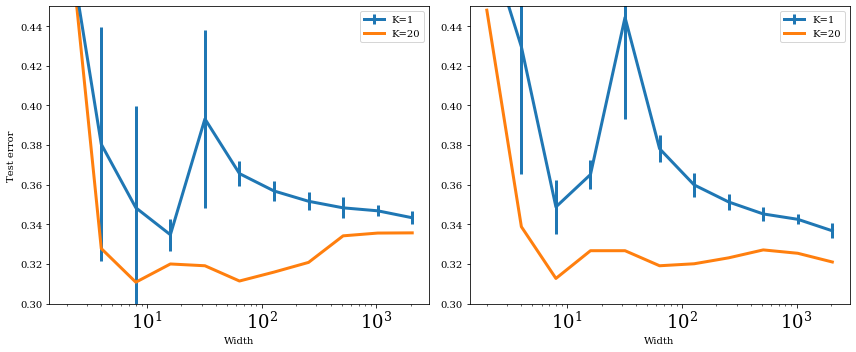

In [10]:
tr_acc_dic = defaultdict(list)
te_acc_dic = defaultdict(list)
te_acc_std_dic = defaultdict(list)
te_acc_ens_dic = defaultdict(list)
te_acc_ens_dic = defaultdict(list)
jamming = {}

for k,v in accuracies.items():
    alpha, width = k
    tr_acc, mean_acc, ens_acc, std_acc = v
    tr_acc_dic[alpha].append([width,tr_acc])
    te_acc_dic[alpha].append([width,mean_acc])
    te_acc_std_dic[alpha].append([width,std_acc])
    te_acc_ens_dic[alpha].append([width,ens_acc])
for dic in [tr_acc_dic, te_acc_dic, te_acc_ens_dic, te_acc_std_dic]:
    for k, v in dic.items():
        dic[k] = np.array(sorted(v, key = lambda x : x[0])) 
for alpha,arr in tr_acc_dic.items():
    width, tr_acc = arr[:,0], arr[:,1]
    ijamming = min(np.argwhere(tr_acc>0.99))
    jamming[alpha] = width[ijamming]
    
        
fig,axarr=plt.subplots(1,2,figsize=(12,5))

for i, alpha in enumerate([10,100]):
    axarr[i].plot(te_acc_ens_dic[alpha][:,0], 1-te_acc_ens_dic[alpha][:,1], color='C1', label='K=20')
    axarr[i].errorbar(te_acc_dic[alpha][:,0], 1-te_acc_dic[alpha][:,1], te_acc_std_dic[alpha][:,1], color='C0', label='K=1')
    #axarr[0]  .axvline(jamming[alpha],color='C%d'%i, ls='-.')
    #axarr[i].axvline(jamming[alpha], ls='-.', color='k', label='jamming')
    
for ax in axarr:
    ax.set_xlabel('Width')
    ax.legend()
    ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_ylim(0.3,0.45)
    handles, labels = ax.get_legend_handles_labels()
    order = [1,0]
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
axarr[0].set_ylabel('Test error')

    
fig.tight_layout()
plt.savefig('Lazy_double_descent.pdf')